# 基于Transformer的机器翻译

大名鼎鼎的《Attention is all your need》这篇文章提出了Transformer结构，其多头注意力机制是更是重中之中。Transformer提出以后其一直是翻译界的最佳模型，种种改进也是基于这个Transformer结构，更有预言自注意力机制可以取代CNN，到目前为止，Transformer依旧是翻译领域的最佳模型，以下将详细介绍各模块，并实现。

要求：
1. 完成代码，实现基本模型，得到测试结果。
2. 改进基本模型，各方面的改进都可以，得到优于基本模型的结果。
3. 上传最后改进模型的运行结果文件，基本模型的结果截图放于文件结尾，并描述一下你做的改进。

1. 数据准备

Multi30k数据集，是torchtext中集成的机器翻译相关的数据集之一，本次作业数据采用Multi30k中的德->英的数据。

In [1]:
import spacy
import torch

from torchtext.data import Field,BucketIterator
from torchtext.datasets import Multi30k

de_seq=spacy.load("de_core_news_sm")
en_seq=spacy.load("en_core_web_sm")

def de_tokenize(text):
    return [word.text for word in de_seq.tokenizer(text)]
def en_tokenize(text):
    return [word.text for word in en_seq.tokenizer(text)]
 
SRC=Field(tokenize=de_tokenize,
         lower=True,
         init_token="<sos>",
         eos_token="<eos>",
         batch_first=True)
 
TRG=Field(tokenize=en_tokenize,
         lower=True,
         init_token="<sos>",
         eos_token="<eos>",
         batch_first=True)

train_data,val_data,test_data=Multi30k.splits(exts=(".de",".en"),
                                             fields=(SRC,TRG))

print(vars(train_data.examples[0]))

SRC.build_vocab(train_data,min_freq=2)
TRG.build_vocab(train_data,min_freq=2)

batch=128
device=torch.device("cuda"  if torch.cuda.is_available() else "cpu")
 
train_iter,val_iter,test_iter=BucketIterator.splits(
(train_data,val_data,test_data),
batch_size=batch,
device=device
)

for example in train_iter:
    src=example.src
    trg=example.trg
    break
 
print(src.shape,trg.shape)

d:\anaconda3\envs\python3.10\lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
torch.Size([128, 28]) torch.Size([128, 32])


2. Positional Encoding

位置编码主要是在词嵌入的基础上添加词序的位置信息，transformer中位置编码的计算公式如下：
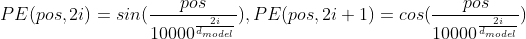
PE代表的是一个与词嵌入相同维度的向量，其中向量中的每个元素对应的位置分别为奇偶。pos代表的是词在句中的位置，取值范围为[0,seq_len)，则代表元素在向量的维度序号，其取值范围为:[0,hid_size/2)（比如词嵌入维度为512，那么0,1向量的i为0；1，2为1...510,512为255）。为嵌入层的维度。


在实现的时候将正弦函数余弦函数里面两个分开计算（也是因为pos和i为变量），最后按位相乘计算。

In [9]:
import math
import torch.nn as nn
class Position_wise(nn.Module):
    def __init__(self,device):
        super(Position_wise,self).__init__()
        self.device=device
    
    def forward(self,src):
        #src[batch src_len hid_size]
        batch=src.shape[0]
        src_len=src.shape[1]
        d_model=src.shape[2]
        
        pos_embedd=torch.zeros_like(src).to(device)
        #pos_embedd[batch src_len d_model]
        
        pos=torch.arange(0,src_len).unsqueeze(0).unsqueeze(-1).to(self.device)
        #pos[1 src_len 1]
        
        pos=pos.repeat(batch,1,int(d_model/2))
        #pos[batch src_len  d_model/2]
        """
        在计算位置嵌入的时候，每个词所在嵌入维度计算上，pos是是一样的
        若嵌入层维度为8其实就是写成
        [
        [0,0,0,0],
        [1,1,1,1],
        [2,2,2,2],
        [3,3,3,3],
        ...]
        [
        [0,0,0,0],
        [1,1,1,1],
        [2,2,2,2],
        [3,3,3,3],
        ...的形式
        ]
        ...
        为了方便计算操作
        """
        div=torch.exp(torch.arange(0,d_model/2)*(-math.log(10000.0)/d_model)).to(device)
        """
        在计算位置嵌入的时候，每个嵌入维度计算中的i，在奇偶上是一样的
        我们的计算应该是希望写成
        [
        [0,0,1,1],
        [0,0,1,1],
        [0,0,1,0],
        ...
        ]
        [
        [0,0,1,1],
        [0,0,1,1],
        [0,0,1,1],
        ...
        ]
        ...
        但是这样是有些冗余的，奇偶完全可以通过切片步长分开（也是基于这个原因pos的d_model写成d_model/2），因此我们写成:
        [
        [0,1],
        [0,1],
        [0,1],
        ...
        ]
        [
        [0,1],
        [0,1],
        [0,1],
        ...
        ]
        ...
        """
        #div[d_model/2]
        pos_embedd[:,:,0::2]=torch.sin(pos*div)
        pos_embedd[:,:,1::2]=torch.cos(pos*div)
        return pos_embedd

In [10]:
###测试：
a=torch.randn(1,4,4).to(device)#假设其为词嵌入
test=Position_wise(device)
pos=test(a)
pos

tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0998,  0.9950],
         [ 0.9093, -0.4161,  0.1987,  0.9801],
         [ 0.1411, -0.9900,  0.2955,  0.9553]]], device='cuda:0')

3. Transformer模块

Transformer模块中主要包含两层，分别是多头自注意力机制层以及简单的前馈层，其模型结构如下：  
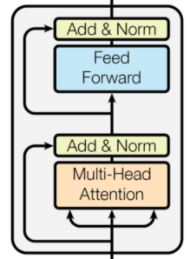  
一个Transfomer经过4步操作，
首先第一步是自注意力机制层，通过自注意力机制层去提取当前词与其他词的特征关系（这种特征关系可能是词序关系，也有可能是语义上的关系）；
第二步则是残差连接与层正则化；
第三步是简单的2层前馈神经网络；
第四步是对前馈层的输出进行残差连接与正则化。
其中我们将多头自注意力机制层与前馈层单独拿出来写成。


3.1. Multi-Head Attention

Transformer模型结构其实不难，以下重点讲解多头注意力机制。其实Transformer主要的创新也就在MultiHeadAttention。
在注意力机制中，我们提到attention的计算要有三个变量，QKV。即查询向量、键向量与值向量。
自注意力机制是注意力机制的变体，其减少了对外部信息的依赖，更擅长捕捉数据或特征的内部相关性。
此外，自注意力机制在文本中的应用，主要是通过计算单词间的互相影响，来解决长距离依赖问题，这解决了CNN视野有限的问题。
而多头则是借鉴了CNN多个卷积核模板，表示关注不同的特征点。


In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self,hid_size,n_heads,device,dropout=0.1):
        super(MultiHeadAttention,self).__init__()
        
        #三个线性层模板
        self.Q = nn.Linear(hid_size,hid_size)
        self.K = nn.Linear(hid_size,hid_size)
        self.V = nn.Linear(hid_size,hid_size)

        #多头拼接层
        self.fc = nn.Linear(hid_size,hid_size)
        
        #各种参数记录
        self.hid_size=hid_size
        self.n_heads=n_heads
        self.heads_dim=hid_size//n_heads
        self.scale=torch.sqrt(torch.FloatTensor([self.heads_dim])).to(device)
        
        self.dropout=nn.Dropout(dropout)
        self.device=device
    
    def forward(self,q,k,v,masked=None):
        #q[batch seq_len hid_size]
        #k[batch seq_len hid_size]
        #v[batch seq_len  hid_size]
        
        #首先经历三个线性变化得到q,v,k向量
        q = self.Q(q)
        k = self.K(k)
        v = self.V(v)

        #q[batch seq_len hid_size]
        #k[batch seq_len hid_size]
        #v[batch seq_len  hid_size]     
        
        batch=q.shape[0]
        
        #由于是多头自注意力，将维度hid_size分成n_heads份
        #每一个多头我们希望其关注不同侧重点
        q=q.reshape(batch,-1,self.n_heads,self.heads_dim)
        #q[batch seq_len n_heads heads_dim]
        q=q.permute(0,2,1,3)
        #q[batch n_heads seq_len heads_dim]       
        k=k.reshape(batch,-1,self.n_heads,self.heads_dim).permute(0,2,1,3)
        v=v.reshape(batch,-1,self.n_heads,self.heads_dim).permute(0,2,1,3)
        
        #计算注意力权重
        #q[batch n_heads seq_len1 heads_dim]   
        #k[batch n_heads seq_len heads_dim]   
        #v[batch n_heads seq_len heads_dim] 
        
        energy = torch.matmul(q,k.permute(0,1,3,2))/self.scale
        #energy[batch n_head seq_len1 seq_len]
        
        #将energy通进行mask忽视pad
        if masked is not None:
            energy=energy.masked_fill(masked==0,-1e10)
        
        attention = torch.softmax(energy,dim=-1)
        #attention[batch n_head seq_len1 seq_len]
        
        #对权重与值向量加权求和得到上下文向量
        context = torch.matmul(self.dropout(attention),v)
        #context[batch n_head seq_len1 heads_dim]
        
        #拼接各个头并进行维度变化输出
        context=context.permute(0,2,1,3).reshape(batch,-1,self.hid_size)
        #context[batch seq_len hid_size]
        output=self.fc(context)
        return output,attention

In [12]:
####测试：
hid_size=256
n_heads=8

mha=MultiHeadAttention(hid_size,n_heads,device).to(device)
masked=(src!=1)
masked=masked.unsqueeze(1).unsqueeze(1).to(device)
testData=torch.randn(batch,src.shape[1],hid_size).to(device)#假src带有位置信息
output,attention=mha(testData,testData,testData,masked)
print(output.shape,attention.shape)

torch.Size([128, 28, 256]) torch.Size([128, 8, 28, 28])


3.2. 前馈神经网络层

此层相对简单，即为两层的前连接映射，第一层为一个非线性映射，激活函数为Relu。
第二层则是将高维转变为嵌入维度。

In [13]:
class FeedfordNN(nn.Module):
    def __init__(self,hid_size,pf_dim,dropout=0.1):
        super(FeedfordNN,self).__init__()
        #hid_size表示嵌入层  隐藏的维度，
        #pf_dim表示升维的维度
        self.fc1=nn.Linear(hid_size,pf_dim)
        self.fc2=nn.Linear(pf_dim,hid_size)
    
        self.dropout=nn.Dropout(dropout)
    def forward(self,src):
        src=self.dropout(torch.relu(self.fc1(src)))
        src=self.fc2(src)
        return src

将这两个模块写好后，完成Transfomrer模块。

In [15]:
class Transform(nn.Module):
    def __init__(self,hid_size,n_heads,pf_dim,device,dropout=0.1):
        super(Transform,self).__init__()
        self.self_attention = MultiHeadAttention(hid_size,n_heads,device,dropout)
        self.self_attention_layer_norm = nn.LayerNorm(hid_size)
        self.feedforward = FeedfordNN(hid_size,pf_dim,dropout)
        self.feedforward_layer_norm = nn.LayerNorm(hid_size)
        
        self.dropout=nn.Dropout(dropout)
    def forward(self,src,src_masked):
        #src为带位置编码的词嵌入
        #src[batch src_len  hid_size]
        
        #经过多头自自注意力
        _src,_ = self.self_attention(src,src,src,src_masked)
        #进行残差连接并层归一化
        #src[batch src_len  hid_size]
        src = self.self_attention_layer_norm(src+self.dropout(_src))
        #src[batch src_len  hid_size]
        #经过前馈神经网络层
        _src = self.feedforward(src)
        #进行残差连接并进行层归一化
        src = self.feedforward_layer_norm(src+self.dropout(_src))
        return src

In [16]:
###测试Transformer模块：
pf_dim=512
trans=Transform(hid_size,n_heads,pf_dim,device).to(device)
output=trans(testData,masked)
print(output.shape)

torch.Size([128, 28, 256])


4. Encoder

基于上面的模块，最终完成Encoder，Encoder的结构如下:  
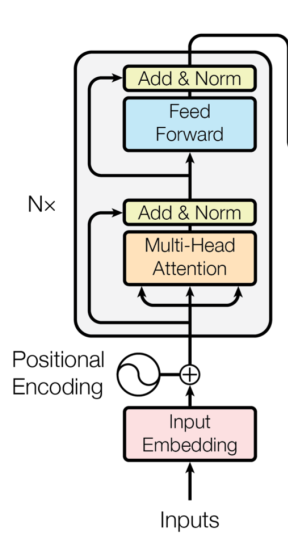  
源句inputs经过位置编码嵌入，到N（6）层Transformer模型中去。略去了在实现中反复的线性维度变化，Transformer将嵌入层与transformer隐层的维度设为相同。经Transformer处理后的源句输入输出维度相同，此时每个词级别的得到一个上下文向量。

In [17]:
class Encoder(nn.Module):
    def __init__(self,hid_size,src_vocab_size,n_layers,n_heads,pf_dim,device,dropout=0.1):
        super(Encoder,self).__init__()
        #hid_size：隐层维度与嵌入层维度
        #src_vocab_size：德语词库大小
        #n_layers：transformer的层结构
        #n_heads:注意力头的数量
        #pf_dim:前馈层上升的维度
 
        self.token_emb=nn.Embedding(src_vocab_size,hid_size,padding_idx=1)
        self.pos_emb=Position_wise(device)
        
        self.layers=nn.ModuleList([
            Transform(hid_size,n_heads,pf_dim,device)
            for _ in range(n_layers)
        ])
 
        self.dropout=nn.Dropout(dropout)
        
        #主归一化功能
        self.scale=torch.sqrt(torch.FloatTensor([hid_size])).to(device)
    
    def forward(self,src):
        
        
        #获取掩码编码
        src_masked=(src!=1)
        #src[batch src_len]
        src_masked=src_masked.unsqueeze(1).unsqueeze(1)
        #src[batch 1 1 src_len]
        
        #对输入的源句嵌入
        #src[batch src_len]
        src=self.token_emb(src)
        #src[batch src_len hid_size]
        
        #对词嵌入嵌入编码信息
        pos=self.pos_emb(src)
        #pos[batch src_len hid_size]
        intput_transformer=self.dropout(src*self.scale+pos)
        #intput_transformer[batch src_len hid_size]
        
        for transform in self.layers:
            intput_transformer=transform(intput_transformer,src_masked)
    
        #intput_transformer[batch src_len hid_size]
        return intput_transformer,src_masked

In [ ]:
###测试：
n_layers=3 # 原论文是6层
src_vocab_size=len(SRC.vocab)
trg_vocab_size=len(TRG.vocab)

enModel=Encoder(hid_size,src_vocab_size,n_layers,n_heads,pf_dim,device).to(device)
output,_=enModel(src)
print(output.shape)

torch.Size([128, 28, 256])


5. Decoder

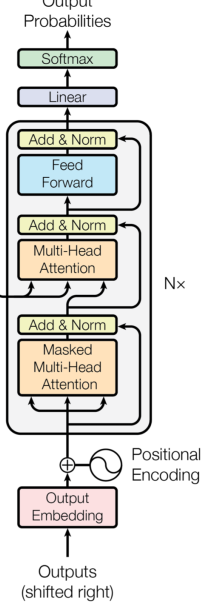
Decoder输入也是的英语也是通过位置嵌入编码，后代入多层的Transformer解码器模块，最后的输出经过一个线性分类层进行判断预测，模型整体框架大致与Endoder相同。

解码器的Trnasformer

相较于编码器中的Transformer模块，其内部结果多了一层masked多头自注意力层，即里面有两层Muti_self-attention。其本质结构是一样的，不过在一些细节上仍有一些差异：

（1）Masked Mutil-Head Attention

在CNN卷积网络是将padding置于句首在使得感受视野规避答案，而在Masked Mutil-Head Attention层中，则是通过mask的操作来盖住答案。即算出能量以后，希望注意力以后忽略答案部分，具体实现的时候采用保留下三角矩阵的方式：

即给energy上三角部分上负无穷，因此我们的mask可以写成：(假设batch=4 max_len=4)
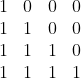

当然我们还要忽略pad部分，因此mask又可以进一步写成：
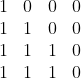

在Masked Mutil-Head Attention中其实主要就是为了求解目标端每个词之间的联系，因此QKV的输入为相同的，即上一层的输出或者英语带有位置编码的嵌入。

（2）Mutil-Head Attention

这一层作用于我们之前理解的attention机制是差不多的，主要的作用在于希望Decoder生成词的时候，在编码器端游一个不同词的参考。因此其输入的KV均来自于Encoder层的输出，而Q来自于当前模块的Masked Mutil-Head Attention。

至于前馈神经网络则是与Encoder无异，也是双层。


In [20]:
class Transformer2(nn.Module):
    def __init__(self,hid_size,n_heads,pf_dim,device,dropout=0.1):
        super(Transformer2,self).__init__()
        self.device=device
        self.masked_mutil_attention = MultiHeadAttention(hid_size,n_heads,device,dropout)
        self.masked_mutil_attention_layer_norm = nn.LayerNorm(hid_size)
        self.mutil_attention = MultiHeadAttention(hid_size,n_heads,device,dropout)
        self.mutil_attention_layer_norm = nn.LayerNorm(hid_size)
        self.feedNN = FeedfordNN(hid_size,pf_dim,dropout)
        self.feedNN_layer_norm = nn.LayerNorm(hid_size)
        
        self.dropout=nn.Dropout(dropout)
        
    def forward(self,enc_outputs,trg,trg_pad_mask,enc_masked):
        #enc_outputs encoder层的输出[batch src_len hide_size]
        #trg  带有位置信息的目标句[batch trg_len hid_size]
        #enc_masked 源句的掩码信息[batch 1 1 src_len]
        #trg_pad_mask[batch 1 1 trg_len]
 
        trg_len=trg.shape[1]
        trg_mask_ans=torch.tril(torch.ones((trg_len,trg_len),device=self.device)).bool()
        #trg_mask_ans [trg_len trg_len]
        
        trg_mask = (trg_pad_mask==0)
        #trg_mask_ans[batch 1 trg_len trg_len]
        
        _trg,_ = self.masked_mutil_attention(trg,trg,trg,trg_mask)
        trg=self.masked_mutil_attention_layer_norm(trg+self.dropout(_trg))
        #trg[batch trg_len hid_dize]
        
        _trg,attention = self.mutil_attention(trg,enc_outputs,enc_outputs,enc_masked)
        trg = self.mutil_attention_layer_norm(trg+self.dropout(_trg))
        #trg[batch trg_len hid_dize]
        
        _trg = self.feedNN(trg)
        trg = self.feedNN_layer_norm(trg+self.dropout(_trg))
        
        return trg,attention

In [21]:
###测试：
trans2=Transformer2(hid_size,n_heads,pf_dim,device).to(device)
testData=torch.randn(batch,trg.shape[1],hid_size).to(device)#假trg带有位置信息
trg_pad_mask=(trg!=1).unsqueeze(1).unsqueeze(1)
output2,a=trans2(output,testData,trg_pad_mask,masked)
print(output2.shape)

torch.Size([128, 32, 256])


In [22]:
class Decoder(nn.Module):
    def __init__(self,hid_size,trg_vocab_size,n_layers,n_heads,pf_dim,device,dropout=0.1):
        super(Decoder,self).__init__()
        #hid_size：隐层维度与嵌入层维度
        #src_vocab_size：德语词库大小
        #n_layers：transformer的层结构
 
        self.token_emb=nn.Embedding(trg_vocab_size,hid_size,padding_idx=1)
        self.pos_emb=Position_wise(device)
        
        self.layers=nn.ModuleList([
            Transformer2(hid_size,n_heads,pf_dim,device)#Encoder与Decoder这里Transofmer有一些区别，这里也是抽象实现
            for _ in range(n_layers)
        ])
        
        #分类
        self.fc=nn.Linear(hid_size,trg_vocab_size)
 
        self.dropout=nn.Dropout(dropout)
        
        #主归一化功能
        self.scale=torch.sqrt(torch.FloatTensor([hid_size])).to(device)
    
    def forward(self,trg,enc_outputs,enc_mask):
        #trg[batch trg_len]
        #enc_outputs[batch src_len hid_size]
        #mask[batch 1 1 src_len]
        
        
        #目标的pad_mask
        pad_mask=(trg!=1).unsqueeze(1).unsqueeze(1)
        #[batch trg_len]
        #对输入的目标句嵌入
        #trg[batch trg_len]
        trg=self.token_emb(trg)
        #trg[batch trg_len hid_size]
        
        #对词嵌入嵌入编码信息
        pos=self.pos_emb(trg)
        #pos[batch trg_len hid_size]
        intput_transformer=self.dropout(trg*self.scale+pos)
        #intput_transformer[batch trg_len hid_size]
        
        for transform in self.layers:
            intput_transformer,_=transform(enc_outputs,intput_transformer,pad_mask,enc_mask)
        #intput_transformer[batch trg_len hid_size]
        
        output=self.fc(intput_transformer)
        #output[batch trg_len trg_vocab_size]
        return output

In [23]:
###测试：
deModel=Decoder(hid_size,trg_vocab_size,n_layers,n_heads,pf_dim,device).to(device)
output3=deModel(trg,output,masked)
print(output3.shape)

torch.Size([128, 32, 5893])


6. Seq2Seq模块

对以上的测试的封装

In [24]:
class Seq2Seq(nn.Module):
    def __init__(self,encoder,decoder):
        super(Seq2Seq,self).__init__()
        self.encoder=encoder
        self.decoder=decoder
    
    def forward(self,src,trg):
        #src[batch src_len]
        #trg[batch src_len]
        enc_outputs,enc_mask=self.encoder(src)
        outputs=self.decoder(trg,enc_outputs,enc_mask)
        return outputs

In [25]:
###测试：
model=Seq2Seq(enModel,deModel).to(device)
outpus=model(src,trg)
print(outpus.shape)

torch.Size([128, 32, 5893])


7. 训练

In [26]:
import math,time
from torch.optim import Adam

epochs=10
clip=1
criterion=nn.CrossEntropyLoss(ignore_index=1)
optim=Adam(model.parameters(),lr= 0.0005)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights)

def train(model, iterator, optimizer, criterion, clip): 
    model.train()
    epoch_loss = 0
    for example in iterator:
        src = example.src
        trg = example.trg
        
        optimizer.zero_grad()
        output=model(src, trg[:,:-1])
        #output = [batch trg_len - 1, trg_vacab_size]
        #trg = [batch size, trg len]
        
        output=output.reshape(-1, trg_vocab_size)
        trg=trg[:,1:].reshape(-1)     
        #output = [batch*trg_len-1,trg_vacab_size]
        #trg = [batch size * trg len - 1]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator,criterion): 
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for example in iterator:
            src = example.src
            trg = example.trg
 
            output=model(src, trg[:,:-1])
            #output = [batch trg_len - 1, trg_vacab_size]
            #trg = [batch size, trg len]
 
            output=output.reshape(-1, trg_vocab_size)
            trg=trg[:,1:].reshape(-1)     
            #output = [batch*trg_len-1,trg_vacab_size]
            #trg = [batch size * trg len - 1]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [27]:
for epoch in range(epochs):
    
    start_time = time.time()
    train_loss = train(model,train_iter,optim,criterion,clip)
    valid_loss = evaluate(model,val_iter,criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
 
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 31s
	Train Loss: 4.528 | Train PPL:  92.535
	 Val. Loss: 4.671 |  Val. PPL: 106.757
Epoch: 02 | Time: 0m 30s
	Train Loss: 3.063 | Train PPL:  21.390
	 Val. Loss: 3.987 |  Val. PPL:  53.892
Epoch: 03 | Time: 0m 31s
	Train Loss: 2.383 | Train PPL:  10.834
	 Val. Loss: 3.629 |  Val. PPL:  37.659
Epoch: 04 | Time: 0m 30s
	Train Loss: 1.984 | Train PPL:   7.270
	 Val. Loss: 3.573 |  Val. PPL:  35.636
Epoch: 05 | Time: 0m 30s
	Train Loss: 1.722 | Train PPL:   5.597
	 Val. Loss: 3.231 |  Val. PPL:  25.295
Epoch: 06 | Time: 0m 31s
	Train Loss: 1.531 | Train PPL:   4.625
	 Val. Loss: 2.994 |  Val. PPL:  19.966
Epoch: 07 | Time: 0m 31s
	Train Loss: 1.383 | Train PPL:   3.987
	 Val. Loss: 3.157 |  Val. PPL:  23.504
Epoch: 08 | Time: 0m 32s
	Train Loss: 1.266 | Train PPL:   3.547
	 Val. Loss: 2.582 |  Val. PPL:  13.218
Epoch: 09 | Time: 0m 32s
	Train Loss: 1.162 | Train PPL:   3.197
	 Val. Loss: 2.947 |  Val. PPL:  19.042
Epoch: 10 | Time: 0m 31s
	Train Loss: 1.077 | Train PPL

8. 测试集上测试: 

In [ ]:
test_loss = evaluate(model,test_iter,criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.014 | Test PPL:  11.250 |


### 基本模型结果

程序的主要部分包括初始化模型权重、定义训练过程、定义评估过程、以及计算每个epoch的运行时间：

1. **参数设置**:
   - `epochs=10`: 设置训练的轮数为10。
   - `clip=1`: 梯度裁剪的阈值，用于防止梯度爆炸。
   - `criterion=nn.CrossEntropyLoss(ignore_index=1)`: 损失函数使用交叉熵损失，`ignore_index=1`表示在计算损失时忽略标签为1的项，通常用于忽略填充（padding）或其他不需要预测的标记。
   - `optim=Adam(model.parameters(), lr=0.0005)`: 使用Adam优化器，学习率设置为0.0005。

2. **初始化模型权重**:
   - 定义`initialize_weights`函数，使用Xavier均匀分布初始化模型的权重，仅对具有多于一维权重的层进行初始化。
   - 通过`model.apply(initialize_weights)`应用这个函数到模型的每一层。

3. **训练过程**:
   - 定义`train`函数，接受模型、数据迭代器、优化器、损失函数和梯度裁剪值作为参数。
   - 在每个epoch中，遍历数据迭代器中的每个批次，进行前向传播、计算损失、反向传播、梯度裁剪、参数更新。
   - 损失通过`reshape`操作将输出和目标调整为一维向量后计算。
   - 返回整个epoch的平均损失。

4. **评估过程**:
   - 定义`evaluate`函数，类似于`train`函数，但模型处于评估模式（`model.eval()`），且不使用梯度计算（`torch.no_grad()`）。
   - 计算整个数据集的平均损失，用于评估模型性能。

5. **计算每个epoch的运行时间**:
   - 定义`epoch_time`函数，接受开始时间和结束时间作为参数，计算并返回运行时间（分钟和秒）。

#### Transformer模型，处理自然语言处理（NLP）任务：

1. **理解输入序列**：通过自注意力机制层，模型能够捕捉到输入序列中各个元素（通常是词或子词单元）之间的内部关系，包括词序和语义关系。

2. **生成上下文向量**：每个输入元素（词）都会经过多层Transformer处理，最终得到一个上下文向量。这个向量包含了关于整个输入序列的信息，对于后续的任务（如分类、生成等）非常有用。

3. **执行特定任务**：根据任务的不同（如机器翻译、文本摘要、情感分析等），Decoder会利用Encoder生成的上下文向量来生成输出序列。在机器翻译任务中，Decoder会逐词生成目标语言的翻译；在文本摘要任务中，它会生成一个简短的摘要；在情感分析任务中，它会输出一个表示情感倾向的标签。


### 描述一下你做了什么改进？

1. **多头注意力机制**：这是Transformer模型的主要创新之一。通过并行地运行多个自注意力机制层，模型能够在不同的表示子空间中共同关注输入序列的不同部分，从而提高了模型的表达能力和泛化能力。

2. **位置编码**：由于自注意力机制本身并不包含位置信息，Transformer模型通过添加位置编码来提供关于单词在序列中位置的信息。这有助于模型理解序列的结构，并生成符合语法和语义规则的输出。

3. **残差连接与层正则化**：这些技术有助于缓解深层网络中的梯度消失和梯度爆炸问题，提高模型的稳定性和训练效率。

4. **更深的网络结构**：通过堆叠更多的Transformer层，模型能够捕捉到更复杂的特征和信息，从而提高性能。然而，这也增加了模型的复杂性和计算成本。

5. **预训练和微调**：近年来，预训练Transformer模型（如BERT、GPT等）在NLP领域取得了巨大成功。这些模型首先在大量无标签文本上进行预训练，学习语言的通用表示。然后，它们可以在特定任务上进行微调，以适应不同的NLP任务。这种迁移学习方法显著提高了模型的性能和适用性。
![alt text](image.png)